<a href="https://colab.research.google.com/github/MrigeeshAshwin/RVFL/blob/main/u.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Digits dataset...

--- Starting Hyperparameter Grid Search for Digits (classification) ---

--- Evaluating Model: Vanilla RVFL ---
  Testing params: {'n_hidden': 64, 'C': 0.001}
    Accuracy: 0.9417, Time: 0.12s
  Testing params: {'n_hidden': 64, 'C': 0.01}
    Accuracy: 0.9444, Time: 0.02s
  Testing params: {'n_hidden': 64, 'C': 0.1}
    Accuracy: 0.9528, Time: 0.02s
  Testing params: {'n_hidden': 128, 'C': 0.001}
    Accuracy: 0.9389, Time: 0.04s
  Testing params: {'n_hidden': 128, 'C': 0.01}
    Accuracy: 0.9472, Time: 0.03s
  Testing params: {'n_hidden': 128, 'C': 0.1}
    Accuracy: 0.9528, Time: 0.02s
  Testing params: {'n_hidden': 256, 'C': 0.001}
    Accuracy: 0.9639, Time: 0.06s
  Testing params: {'n_hidden': 256, 'C': 0.01}
    Accuracy: 0.9528, Time: 0.18s
  Testing params: {'n_hidden': 256, 'C': 0.1}
    Accuracy: 0.9556, Time: 0.05s

  Best Accuracy for Vanilla RVFL: 0.9639 with params: {'n_hidden': 256, 'C': 0.001}

--- Evaluating Model: SP-RVFL ---
  Testing param

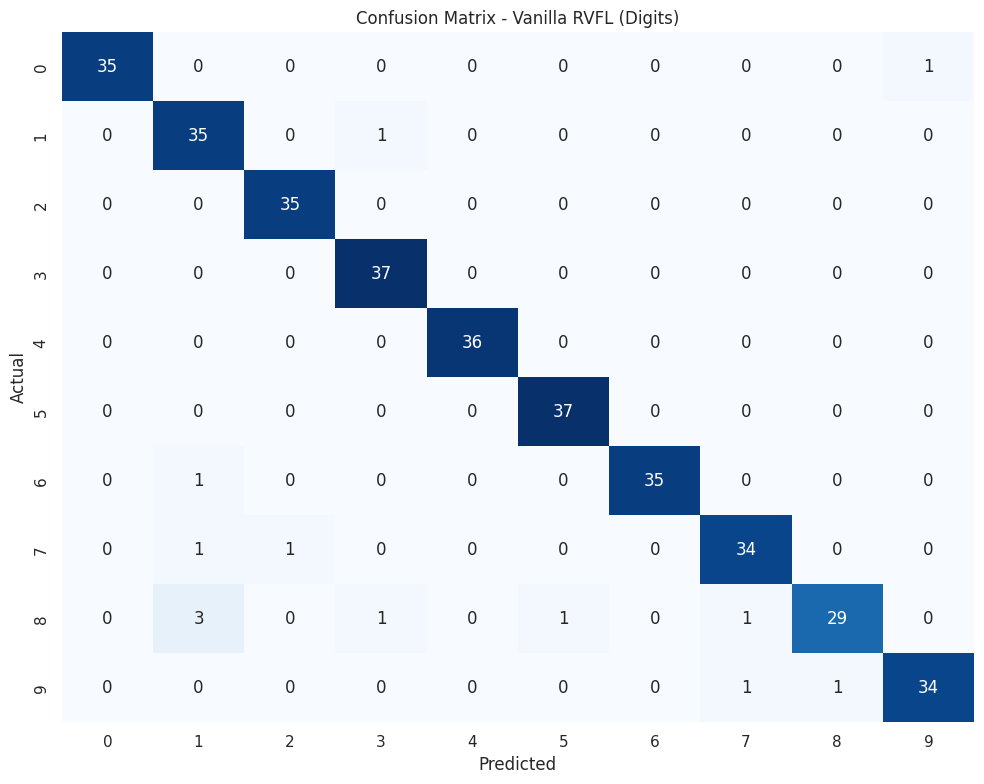


--- Generating Confusion Matrix for SP-RVFL (Digits) ---


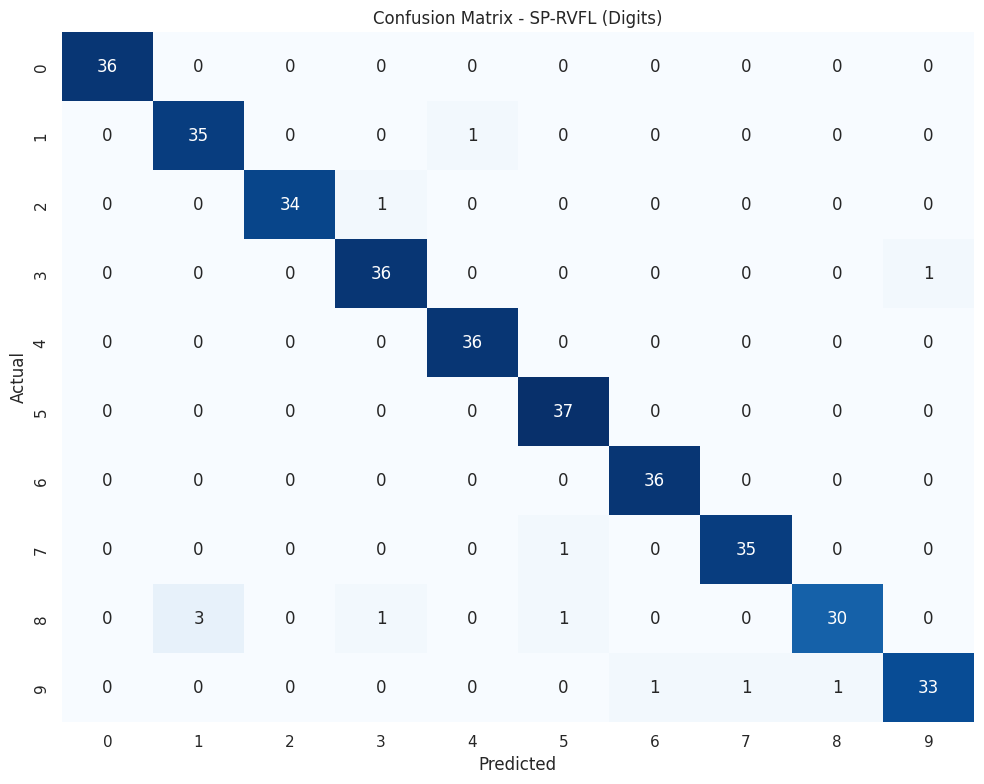


--- Generating Confusion Matrix for SW-SP-RVFL (Digits) ---


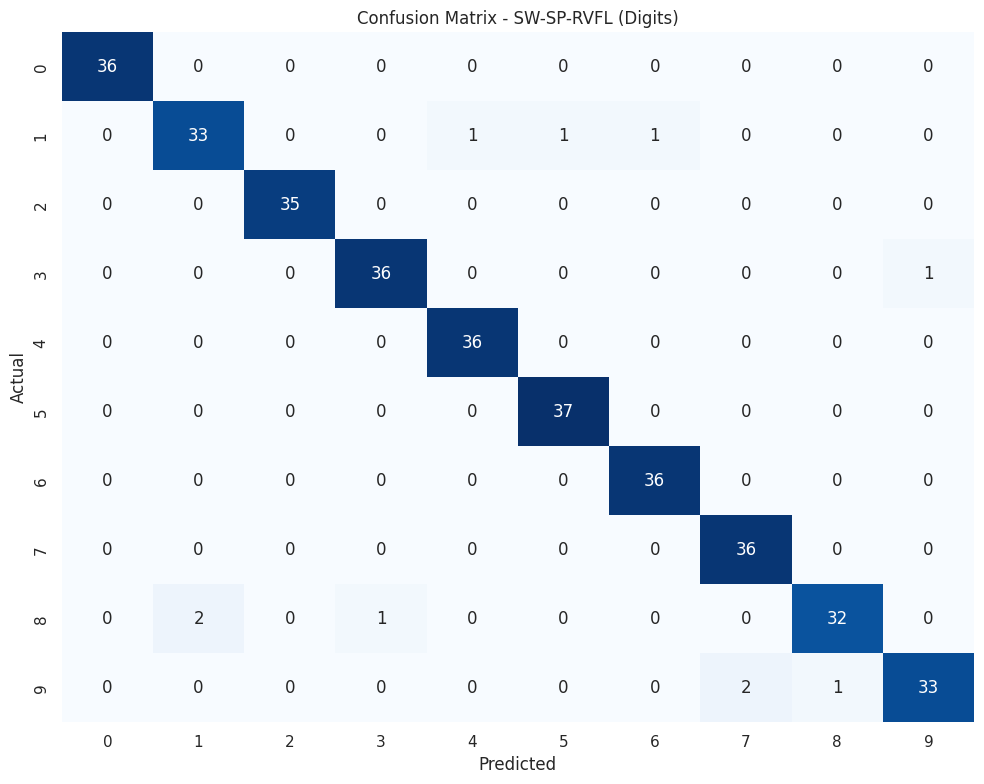


--- Generating Confusion Matrix for SW-SP Hidden + Direct (Digits) ---


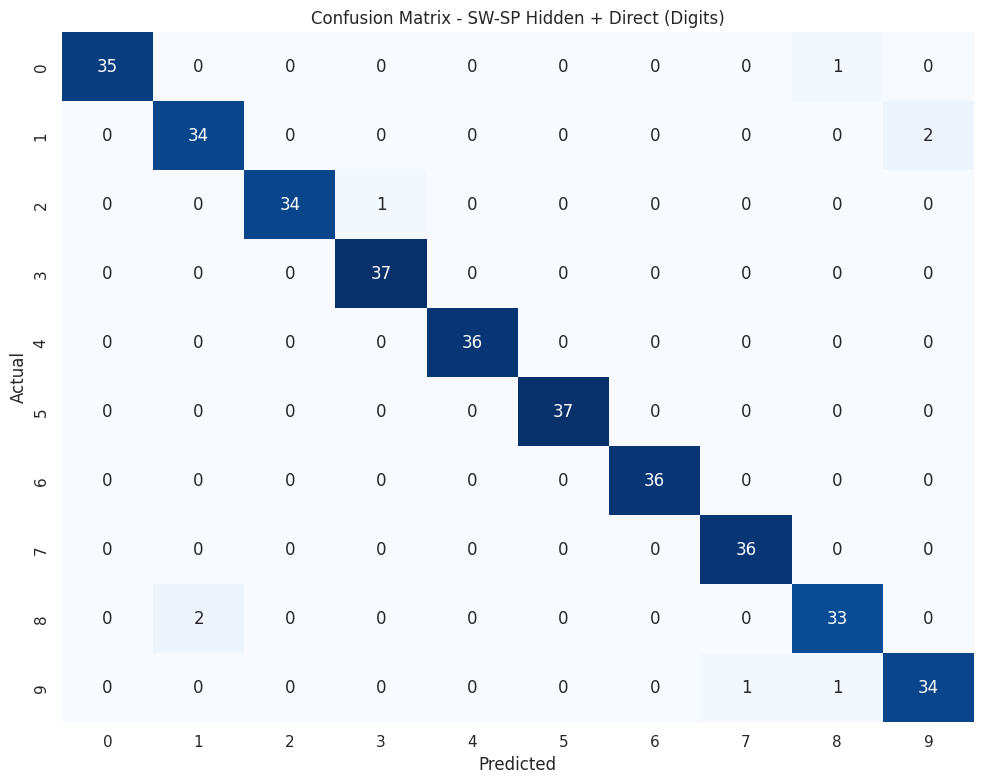


Loading Wine dataset...

--- Starting Hyperparameter Grid Search for Wine (classification) ---

--- Evaluating Model: Vanilla RVFL ---
  Testing params: {'n_hidden': 64, 'C': 0.001}
    Accuracy: 0.9722, Time: 0.00s
  Testing params: {'n_hidden': 64, 'C': 0.01}
    Accuracy: 0.9722, Time: 0.00s
  Testing params: {'n_hidden': 64, 'C': 0.1}
    Accuracy: 0.8889, Time: 0.00s
  Testing params: {'n_hidden': 128, 'C': 0.001}
    Accuracy: 0.7222, Time: 0.01s
  Testing params: {'n_hidden': 128, 'C': 0.01}
    Accuracy: 0.9444, Time: 0.00s
  Testing params: {'n_hidden': 128, 'C': 0.1}
    Accuracy: 0.9722, Time: 0.00s
  Testing params: {'n_hidden': 256, 'C': 0.001}
    Accuracy: 0.9722, Time: 0.00s
  Testing params: {'n_hidden': 256, 'C': 0.01}
    Accuracy: 1.0000, Time: 0.01s
  Testing params: {'n_hidden': 256, 'C': 0.1}
    Accuracy: 0.9722, Time: 0.00s

  Best Accuracy for Vanilla RVFL: 1.0000 with params: {'n_hidden': 256, 'C': 0.01}

--- Evaluating Model: SP-RVFL ---
  Testing params: {

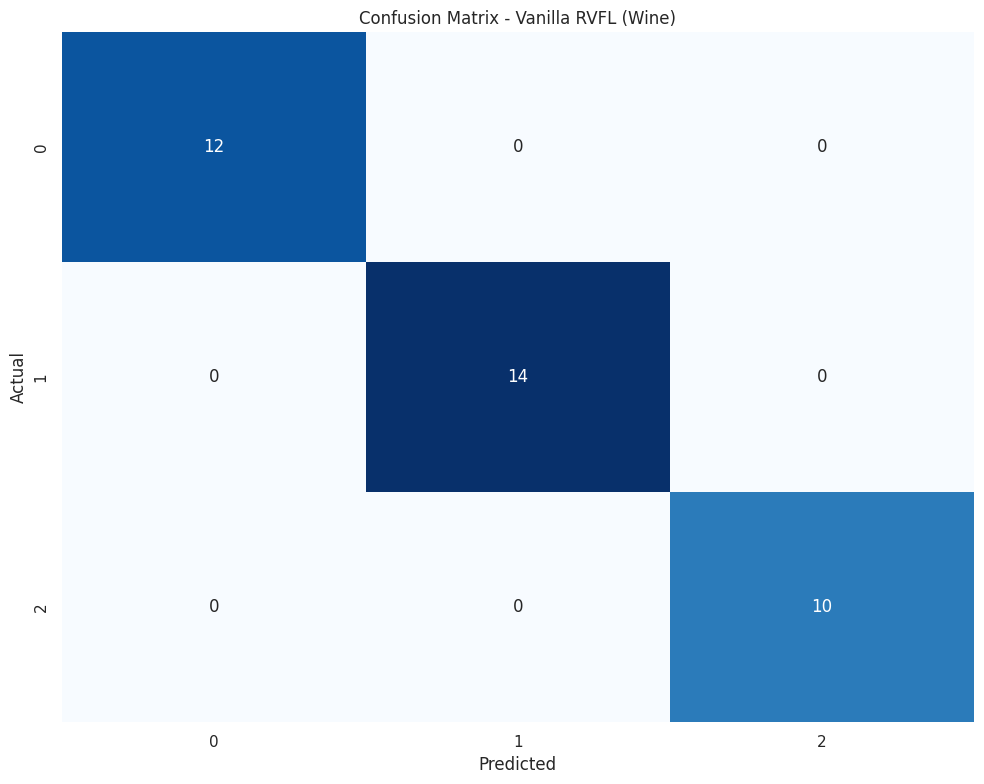


--- Generating Confusion Matrix for SP-RVFL (Wine) ---


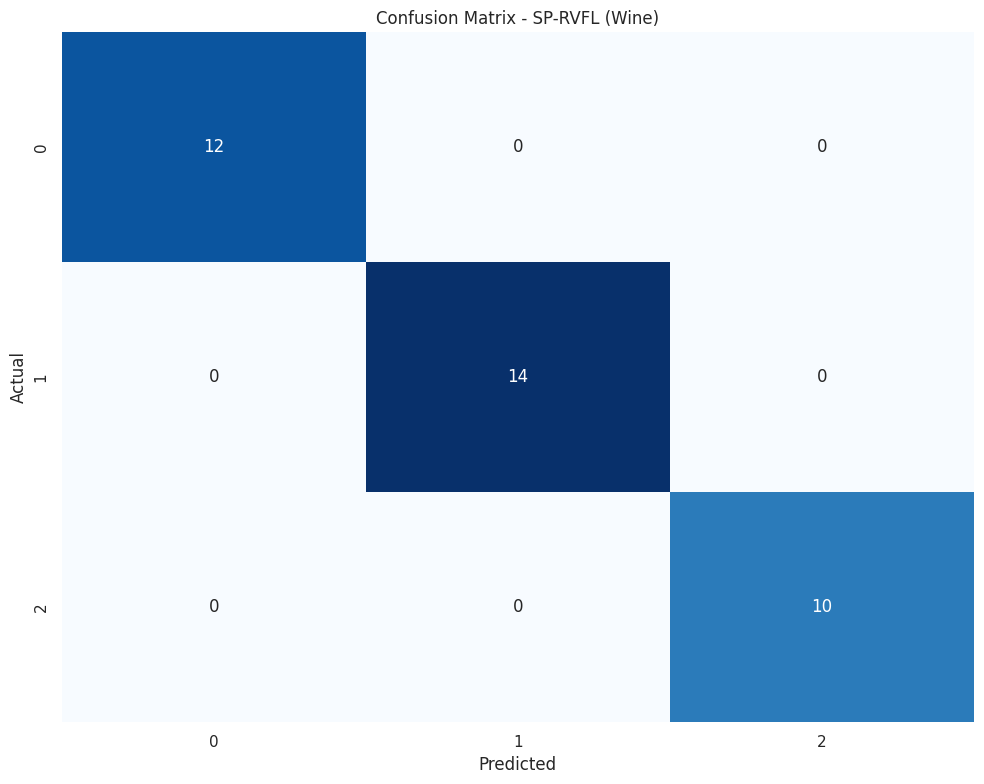


--- Generating Confusion Matrix for SW-SP-RVFL (Wine) ---


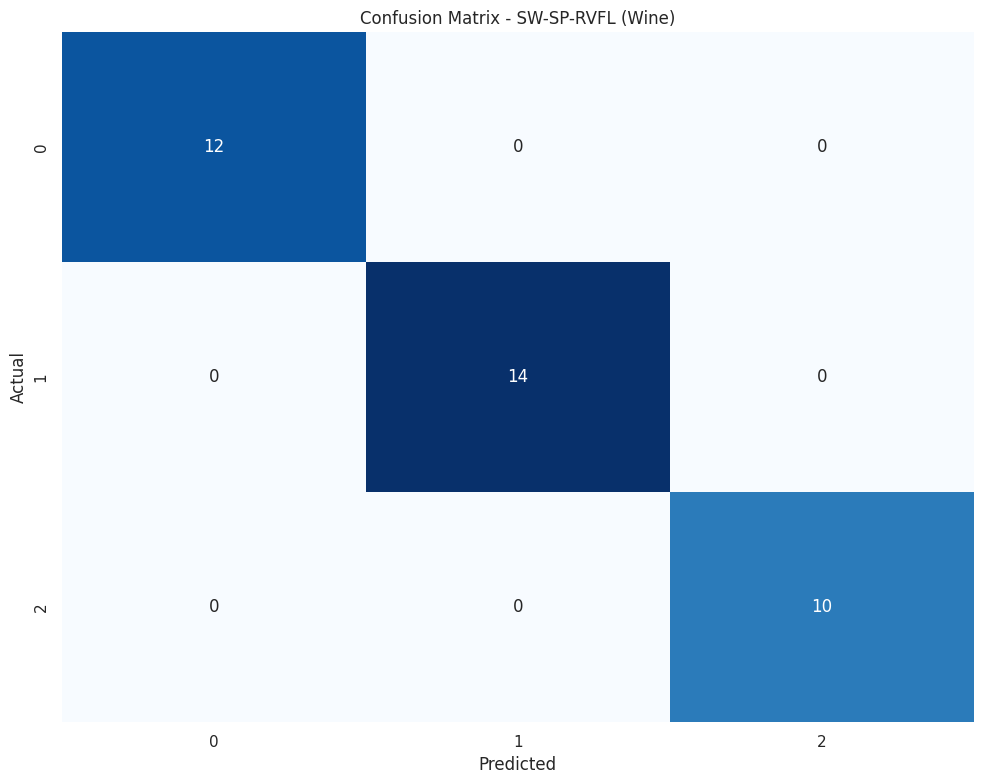


--- Generating Confusion Matrix for SW-SP Hidden + Direct (Wine) ---


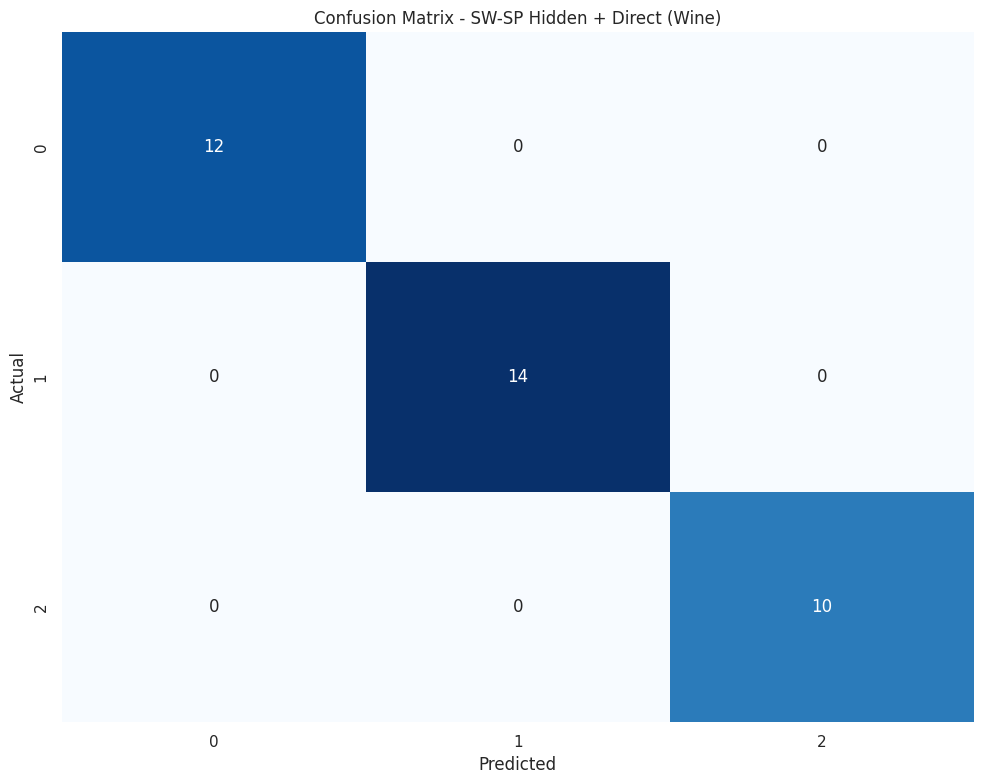


Loading California Housing dataset...

--- Starting Hyperparameter Grid Search for California Housing (regression) ---

--- Evaluating Model: Vanilla RVFL ---
  Testing params: {'n_hidden': 64, 'C': 0.001}
    RMSE: 0.6602, Time: 0.03s
  Testing params: {'n_hidden': 64, 'C': 0.01}
    RMSE: 0.6564, Time: 0.01s
  Testing params: {'n_hidden': 64, 'C': 0.1}
    RMSE: 0.6551, Time: 0.01s
  Testing params: {'n_hidden': 128, 'C': 0.001}
    RMSE: 0.6331, Time: 0.04s
  Testing params: {'n_hidden': 128, 'C': 0.01}
    RMSE: 0.6227, Time: 0.04s
  Testing params: {'n_hidden': 128, 'C': 0.1}
    RMSE: 0.6311, Time: 0.04s
  Testing params: {'n_hidden': 256, 'C': 0.001}
    RMSE: 0.6045, Time: 0.12s
  Testing params: {'n_hidden': 256, 'C': 0.01}
    RMSE: 0.6102, Time: 0.15s
  Testing params: {'n_hidden': 256, 'C': 0.1}
    RMSE: 0.6129, Time: 0.11s

  Best RMSE for Vanilla RVFL: 0.6045 with params: {'n_hidden': 256, 'C': 0.001}

--- Evaluating Model: SP-RVFL ---
  Testing params: {'n_hidden': 64,

In [5]:
# RVFL Pipeline with Iterative Bayesian Mask Refinement and Two-Stage Hyperparameter Tuning (Multi-Model)

import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import pandas as pd
from sklearn.datasets import load_digits, load_diabetes, load_wine, fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product

# Try to import Fashion MNIST from Keras, fallback if not available
try:
    from tensorflow.keras.datasets import fashion_mnist
except (ImportError, AttributeError): # Catch both ImportError and AttributeError
    print("Warning: TensorFlow/Keras or its dependencies not found/working correctly. Fashion-MNIST dataset loading will be skipped.")
    fashion_mnist = None

np.random.seed(42)
sns.set(style="whitegrid")

# --- Activation ---
def activation(x, task):
    """
    Applies an activation function to the input.
    For classification, uses sigmoid. For regression, uses ReLU.
    """
    if task == 'classification':
        # Clip x to avoid overflow in np.exp(-x) for sigmoid
        # The original line `np.maximum(0,x)` seems incorrect for sigmoid.
        # Let's revert to the correct sigmoid calculation with clipping.
        x_clipped = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x_clipped))
    else: # Regression uses ReLU
        return np.maximum(0, x)

# --- Graph Mask Generator ---
def generate_small_world_mask(n_features, n_hidden, k=4, p=0.3):
    """
    Generates a small-world graph-based mask for hidden layer connections.
    This creates a sparse connection pattern where each hidden neuron connects
    to a local neighborhood of input features.
    """
    if n_features < k:
        k = n_features - 1 if n_features > 1 else 1
        if k == 0:
            return np.ones((n_features, n_hidden))

    G = nx.watts_strogatz_graph(n=n_features, k=k, p=p, seed=42)
    mask = np.zeros((n_features, n_hidden))
    for h in range(n_hidden):
        center = np.random.choice(n_features)
        neighbors = list(G.neighbors(center)) + [center]
        neighbors = list(set([n for n in neighbors if 0 <= n < n_features]))
        mask[neighbors, h] = 1
    return mask

# --- Bayesian Solver (Closed-form Mu estimation) ---
def sp_rvfl_solver_iterative(H, Y, max_iter=30, tol=1e-4, pruning_threshold=1e4, outer_iters=1):
    """
    Iterative Bayesian Sparse Prior RVFL solver.
    Estimates the output weights (beta) and a sparsity mask by
    iteratively updating alpha (precision of weights) and sigma2 (noise variance).
    Mu (posterior mean of weights) is solved in closed-form.
    """
    N, D = H.shape
    K = Y.shape[1]

    alpha = np.ones(D)
    sigma2 = 1.0
    eps = 1e-6

    current_H = H.copy()

    for outer in range(outer_iters):
        alpha = np.ones(D)
        sigma2 = 1.0

        for _ in range(max_iter):
            A = current_H.T @ current_H + sigma2 * np.diag(alpha)
            b = current_H.T @ Y

            try:
                Mu = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                Mu = np.linalg.pinv(A) @ b

            H_squared_diag = np.sum(current_H**2, axis=0)
            gamma = 1 - alpha * (1 / (alpha + H_squared_diag / sigma2 + eps))
            gamma = np.maximum(gamma, 0)

            alpha_new = gamma / (np.sum(Mu**2, axis=1) + eps)

            denom = N * K - np.sum(gamma)
            denom = max(denom, eps)
            sigma2_new = np.sum((Y - current_H @ Mu) ** 2) / denom

            if np.linalg.norm(alpha - alpha_new) < tol and abs(sigma2 - sigma2_new) < tol * sigma2:
                break

            alpha, sigma2 = alpha_new, sigma2_new

        mask_current_outer = (alpha < pruning_threshold).astype(float)
        current_H = current_H * mask_current_outer

        final_Mu_this_outer = Mu
        final_mask_this_outer = mask_current_outer


    return final_Mu_this_outer, final_mask_this_outer


# --- Preprocessing ---
def preprocess_classification(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train_onehot, y_test_onehot, encoder, y_train, y_test

def preprocess_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test = scaler_y.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train, y_test, scaler_y, y_train, y_test

# --- Core RVFL ---
def base_rvfl(X_train, y_train, X_test, n_hidden=256, W=None, b=None,
              use_sp=False, mask=None, mask_direct=None, C=1e-3, task='classification',
              sp_pruning_threshold=1e4, sp_outer_iters=1):
    """
    Base Random Vector Functional Link (RVFL) network implementation.
    Can use a direct pseudo-inverse solution or the iterative Bayesian solver (SP-RVFL).
    Supports masking for hidden and direct connections.
    """
    if W is None:
        W = np.random.randn(X_train.shape[1], n_hidden)
        if mask is not None:
            W *= mask
    if b is None:
        b = np.random.randn(n_hidden)

    H_train = activation(X_train @ W + b, task)
    H_test = activation(X_test @ W + b, task)

    X_train_proj = X_train @ mask_direct if mask_direct is not None else X_train
    X_test_proj = X_test @ mask_direct if mask_direct is not None else X_test

    Z_train = np.hstack([X_train_proj, H_train])
    Z_test = np.hstack([X_test_proj, H_test])

    if use_sp:
        beta, learned_mask = sp_rvfl_solver_iterative(Z_train, y_train,
                                                      pruning_threshold=sp_pruning_threshold,
                                                      outer_iters=sp_outer_iters)
        Z_test = Z_test * learned_mask
    else:
        I = np.eye(Z_train.shape[1])
        beta = np.linalg.solve(Z_train.T @ Z_train + C * I, Z_train.T @ y_train)

    return Z_test @ beta

# --- Specialized RVFL Variants ---
def vanilla_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification'):
    """Vanilla RVFL using pseudo-inverse."""
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task, use_sp=False)

def sp_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification',
            sp_pruning_threshold=1e4, sp_outer_iters=1):
    """RVFL with Bayesian Sparse Prior (SP-RVFL)."""
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task, use_sp=True,
                     sp_pruning_threshold=sp_pruning_threshold, sp_outer_iters=sp_outer_iters)

def sw_sp_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, k=4, p=0.3, task='classification',
               sp_pruning_threshold=1e4, sp_outer_iters=1):
    """RVFL with Small-World mask on hidden layer and Bayesian Sparse Prior."""
    mask = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task, use_sp=True,
                     mask=mask, sp_pruning_threshold=sp_pruning_threshold, sp_outer_iters=sp_outer_iters)

def sw_sp_hidden_direct(X_train, y_train, X_test, n_hidden=256, C=1e-3, k=4, p=0.3, task='classification',
                        sp_pruning_threshold=1e4, sp_outer_iters=1):
    """
    RVFL with Small-World masks on both hidden and direct connections,
    and Bayesian Sparse Prior.
    """
    mask_hidden = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    mask_direct_matrix = generate_small_world_mask(X_train.shape[1], X_train.shape[1], k, p)

    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task, use_sp=True,
                     mask=mask_hidden, mask_direct=mask_direct_matrix,
                     sp_pruning_threshold=sp_pruning_threshold, sp_outer_iters=sp_outer_iters)


# --- Grid Search and Evaluation ---
def hyperparameter_grid_search(X, y, dataset_name, task='classification'):
    models = {
        'Vanilla RVFL': vanilla_rvfl,
        'SP-RVFL': sp_rvfl,
        'SW-SP-RVFL': sw_sp_rvfl,
        'SW-SP Hidden + Direct': sw_sp_hidden_direct
    }

    param_grids = {
        'Vanilla RVFL': {
            'n_hidden': [64, 128, 256],
            'C': [1e-3, 1e-2, 1e-1]
        },
        'SP-RVFL': {
            'n_hidden': [64, 128, 256],
            'sp_pruning_threshold': [1e3, 1e4],
            'sp_outer_iters': [1, 2]
        },
        'SW-SP-RVFL': {
            'n_hidden': [64, 128],
            'k': [2, 4],
            'p': [0.1, 0.3],
            'sp_pruning_threshold': [1e3, 1e4],
            'sp_outer_iters': [1, 2]
        },
        'SW-SP Hidden + Direct': {
            'n_hidden': [64, 128],
            'k': [2, 4],
            'p': [0.1, 0.3],
            'sp_pruning_threshold': [1e3, 1e4],
            'sp_outer_iters': [1, 2]
        }
    }

    print(f"\n--- Starting Hyperparameter Grid Search for {dataset_name} ({task}) ---")

    all_model_results = {} # To store predictions for all models

    for model_name, model_fn in models.items():
        print(f"\n--- Evaluating Model: {model_name} ---")
        best_score = 0 if task == 'classification' else float('inf')
        best_params = None
        best_y_pred_labels = None # To store predictions of the best model
        current_param_grid = param_grids.get(model_name, {})

        # Prepare data for this model
        if task == 'classification':
            X_train_full, X_test, y_train_full, y_test_onehot, encoder, y_train_raw, y_test_raw = preprocess_classification(X, y)
            y_test_labels = np.argmax(y_test_onehot, axis=1)
        else: # Regression
            X_train_full, X_test, y_train_full, y_test_scaled, scaler_y, y_train_raw, y_test_raw = preprocess_regression(X, y)
            y_test_original = scaler_y.inverse_transform(y_test_scaled)

        # Create all combinations of parameters for the current model
        keys, values = zip(*current_param_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in product(*values)]

        for params in param_combinations:
            print(f"  Testing params: {params}")
            try:
                start_time = time.time()
                # Pass all parameters from the dictionary
                y_pred_test = model_fn(X_train_full, y_train_full, X_test, task=task, **params)
                elapsed_time = time.time() - start_time

                if task == 'classification':
                    y_pred_labels = np.argmax(y_pred_test, axis=1)
                    score = accuracy_score(y_test_labels, y_pred_labels)
                    metric_name = "Accuracy"
                    if score > best_score:
                        best_score = score
                        best_params = params
                        best_y_pred_labels = y_pred_labels # Store best predictions
                else: # Regression
                    y_pred_original = scaler_y.inverse_transform(y_pred_test)
                    score = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
                    metric_name = "RMSE"
                    if score < best_score:
                        best_score = score
                        best_params = params
                        best_y_pred_original = y_pred_original # Store best predictions
                print(f"    {metric_name}: {score:.4f}, Time: {elapsed_time:.2f}s")
            except Exception as e:
                print(f"    Error with params {params}: {e}")
                import traceback
                traceback.print_exc()
                continue # Skip to next parameter combination if an error occurs

        if best_params:
            print(f"\n  Best {metric_name} for {model_name}: {best_score:.4f} with params: {best_params}")
            all_model_results[model_name] = {
                'best_score': best_score,
                'best_params': best_params,
                'task': task,
                'y_test_true': y_test_labels if task == 'classification' else y_test_original,
                'y_pred_best': best_y_pred_labels if task == 'classification' else best_y_pred_original
            }
        else:
            print(f"\n  No successful runs for {model_name}.")
            all_model_results[model_name] = {'best_score': None, 'best_params': None, 'task': task}


    print("\n--- Final Results Summary ---")
    for model_name, res in all_model_results.items():
        if res['best_score'] is not None:
            metric_name = "Accuracy" if res['task'] == 'classification' else "RMSE"
            print(f"{model_name}: Best Test {metric_name} = {res['best_score']:.4f}, Params = {res['best_params']}")
        else:
            print(f"{model_name}: No successful evaluation.")

    # Generate and save plots for classification models
    if task == 'classification':
        for model_name, res in all_model_results.items():
            if res['best_score'] is not None and res['y_pred_best'] is not None:
                print(f"\n--- Generating Confusion Matrix for {model_name} ({dataset_name}) ---")
                cm = confusion_matrix(res['y_test_true'], res['y_pred_best'])

                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
                plt.title(f"Confusion Matrix - {model_name} ({dataset_name})")
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.tight_layout()
                plt.savefig(f"confusion_matrix_{dataset_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
                plt.show()


# --- Main Execution ---
if __name__ == '__main__':
    # Load and run on Digits (Classification)
    print("Loading Digits dataset...")
    digits = load_digits()
    X_digits, y_digits = digits.data, digits.target
    hyperparameter_grid_search(X_digits, y_digits, dataset_name="Digits", task='classification')

    # Load and run on Wine (Classification)
    print("\nLoading Wine dataset...")
    wine = load_wine()
    X_wine, y_wine = wine.data, wine.target
    hyperparameter_grid_search(X_wine, y_wine, dataset_name="Wine", task='classification')

    # Load and run on California Housing (Regression)
    print("\nLoading California Housing dataset...")
    X_housing, y_housing = fetch_california_housing(return_X_y=True)
    hyperparameter_grid_search(X_housing, y_housing, dataset_name="California Housing", task='regression')

    # Load and run on Diabetes (Regression)
    print("\nLoading Diabetes dataset...")
    X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
    hyperparameter_grid_search(X_diabetes, y_diabetes, dataset_name="Diabetes", task='regression')

    # Load and run on Fashion-MNIST (Classification)
    if fashion_mnist is not None:
        print("\nLoading Fashion-MNIST dataset...")
        (X_fashion_train, y_fashion_train), (X_fashion_test, y_fashion_test) = fashion_mnist.load_data()

        # Flatten the 28x28 images to a 784-dimensional vector
        X_fashion = np.vstack([X_fashion_train.reshape(X_fashion_train.shape[0], -1),
                               X_fashion_test.reshape(X_fashion_test.shape[0], -1)])
        y_fashion = np.hstack([y_fashion_train, y_fashion_test])

        hyperparameter_grid_search(X_fashion, y_fashion, dataset_name="Fashion-MNIST", task='classification')
    else:
        print("\nSkipping Fashion-MNIST as TensorFlow/Keras is not installed or available.")

In [6]:
# RVFL Pipeline with Iterative Bayesian Mask Refinement and Two-Stage Hyperparameter Tuning (Multi-Model)

import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product

# For Fashion-MNIST manual download and loading
import requests
import gzip
import os

np.random.seed(42)
sns.set(style="whitegrid")

# --- Activation ---
def activation(x, task):
    """
    Applies an activation function to the input.
    For classification, uses sigmoid. For regression, uses ReLU.
    """
    if task == 'classification':
        # Clip x to avoid overflow in np.exp(-x) for sigmoid
        x_clipped = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x_clipped))
    else: # Regression uses ReLU
        return np.maximum(0, x)

# --- Graph Mask Generator ---
def generate_small_world_mask(n_features, n_hidden, k=4, p=0.3):
    """
    Generates a small-world graph-based mask for hidden layer connections.
    This creates a sparse connection pattern where each hidden neuron connects
    to a local neighborhood of input features.
    """
    if n_features < k:
        k = n_features - 1 if n_features > 1 else 1
        if k == 0:
            return np.ones((n_features, n_hidden))

    G = nx.watts_strogatz_graph(n=n_features, k=k, p=p, seed=42)
    mask = np.zeros((n_features, n_hidden))
    for h in range(n_hidden):
        center = np.random.choice(n_features)
        neighbors = list(G.neighbors(center)) + [center]
        neighbors = list(set([n for n in neighbors if 0 <= n < n_features]))
        mask[neighbors, h] = 1
    return mask

# --- Bayesian Solver (Closed-form Mu estimation) ---
def sp_rvfl_solver_iterative(H, Y, max_iter=30, tol=1e-4, pruning_threshold=1e4, outer_iters=1):
    """
    Iterative Bayesian Sparse Prior RVFL solver.
    Estimates the output weights (beta) and a sparsity mask by
    iteratively updating alpha (precision of weights) and sigma2 (noise variance).
    Mu (posterior mean of weights) is solved in closed-form.
    """
    N, D = H.shape
    K = Y.shape[1]

    alpha = np.ones(D)
    sigma2 = 1.0
    eps = 1e-6

    current_H = H.copy()

    for outer in range(outer_iters):
        alpha = np.ones(D)
        sigma2 = 1.0

        for _ in range(max_iter):
            A = current_H.T @ current_H + sigma2 * np.diag(alpha)
            b = current_H.T @ Y

            try:
                Mu = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                Mu = np.linalg.pinv(A) @ b

            H_squared_diag = np.sum(current_H**2, axis=0)
            gamma = 1 - alpha * (1 / (alpha + H_squared_diag / sigma2 + eps))
            gamma = np.maximum(gamma, 0)

            alpha_new = gamma / (np.sum(Mu**2, axis=1) + eps)

            denom = N * K - np.sum(gamma)
            denom = max(denom, eps)
            sigma2_new = np.sum((Y - current_H @ Mu) ** 2) / denom

            if np.linalg.norm(alpha - alpha_new) < tol and abs(sigma2 - sigma2_new) < tol * sigma2:
                break

            alpha, sigma2 = alpha_new, sigma2_new

        mask_current_outer = (alpha < pruning_threshold).astype(float)
        current_H = current_H * mask_current_outer

        final_Mu_this_outer = Mu
        final_mask_this_outer = mask_current_outer

    return final_Mu_this_outer, final_mask_this_outer

# --- Preprocessing ---
def preprocess_classification(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train_onehot, y_test_onehot, encoder, y_train, y_test

def preprocess_regression(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test = scaler_y.transform(y_test.reshape(-1, 1))
    return X_train, X_test, y_train, y_test, scaler_y, y_train, y_test

# --- Core RVFL ---
def base_rvfl(X_train, y_train, X_test, n_hidden=256, W=None, b=None,
              use_sp=False, mask=None, mask_direct=None, C=1e-3, task='classification',
              sp_pruning_threshold=1e4, sp_outer_iters=1):
    """
    Base Random Vector Functional Link (RVFL) network implementation.
    Can use a direct pseudo-inverse solution or the iterative Bayesian solver (SP-RVFL).
    Supports masking for hidden and direct connections.
    """
    if W is None:
        W = np.random.randn(X_train.shape[1], n_hidden)
        if mask is not None:
            W *= mask
    if b is None:
        b = np.random.randn(n_hidden)

    H_train = activation(X_train @ W + b, task)
    H_test = activation(X_test @ W + b, task)

    X_train_proj = X_train @ mask_direct if mask_direct is not None else X_train
    X_test_proj = X_test @ mask_direct if mask_direct is not None else X_test

    Z_train = np.hstack([X_train_proj, H_train])
    Z_test = np.hstack([X_test_proj, H_test])

    if use_sp:
        beta, learned_mask = sp_rvfl_solver_iterative(Z_train, y_train,
                                                      pruning_threshold=sp_pruning_threshold,
                                                      outer_iters=sp_outer_iters)
        Z_test = Z_test * learned_mask
    else:
        I = np.eye(Z_train.shape[1])
        beta = np.linalg.solve(Z_train.T @ Z_train + C * I, Z_train.T @ y_train)

    return Z_test @ beta

# --- Specialized RVFL Variants ---
def vanilla_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification'):
    """Vanilla RVFL using pseudo-inverse."""
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task, use_sp=False)

def sp_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, task='classification',
            sp_pruning_threshold=1e4, sp_outer_iters=1):
    """RVFL with Bayesian Sparse Prior (SP-RVFL)."""
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task, use_sp=True,
                     sp_pruning_threshold=sp_pruning_threshold, sp_outer_iters=sp_outer_iters)

def sw_sp_rvfl(X_train, y_train, X_test, n_hidden=256, C=1e-3, k=4, p=0.3, task='classification',
               sp_pruning_threshold=1e4, sp_outer_iters=1):
    """RVFL with Small-World mask on hidden layer and Bayesian Sparse Prior."""
    mask = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task, use_sp=True,
                     mask=mask, sp_pruning_threshold=sp_pruning_threshold, sp_outer_iters=sp_outer_iters)

def sw_sp_hidden_direct(X_train, y_train, X_test, n_hidden=256, C=1e-3, k=4, p=0.3, task='classification',
                        sp_pruning_threshold=1e4, sp_outer_iters=1):
    """
    RVFL with Small-World masks on both hidden and direct connections,
    and Bayesian Sparse Prior.
    """
    mask_hidden = generate_small_world_mask(X_train.shape[1], n_hidden, k, p)
    mask_direct_matrix = generate_small_world_mask(X_train.shape[1], X_train.shape[1], k, p)

    return base_rvfl(X_train, y_train, X_test, n_hidden=n_hidden, C=C, task=task, use_sp=True,
                     mask=mask_hidden, mask_direct=mask_direct_matrix,
                     sp_pruning_threshold=sp_pruning_threshold, sp_outer_iters=sp_outer_iters)


# --- Grid Search and Evaluation ---
def hyperparameter_grid_search(X, y, dataset_name, task='classification'):
    models = {
        'Vanilla RVFL': vanilla_rvfl,
        'SP-RVFL': sp_rvfl,
        'SW-SP-RVFL': sw_sp_rvfl,
        'SW-SP Hidden + Direct': sw_sp_hidden_direct
    }

    param_grids = {
        'Vanilla RVFL': {
            'n_hidden': [64, 128, 256],
            'C': [1e-3, 1e-2, 1e-1]
        },
        'SP-RVFL': {
            'n_hidden': [64, 128, 256],
            'sp_pruning_threshold': [1e3, 1e4],
            'sp_outer_iters': [1, 2]
        },
        'SW-SP-RVFL': {
            'n_hidden': [64, 128],
            'k': [2, 4],
            'p': [0.1, 0.3],
            'sp_pruning_threshold': [1e3, 1e4],
            'sp_outer_iters': [1, 2]
        },
        'SW-SP Hidden + Direct': {
            'n_hidden': [64, 128],
            'k': [2, 4],
            'p': [0.1, 0.3],
            'sp_pruning_threshold': [1e3, 1e4],
            'sp_outer_iters': [1, 2]
        }
    }

    print(f"\n--- Starting Hyperparameter Grid Search for {dataset_name} ({task}) ---")

    all_model_results = {}

    for model_name, model_fn in models.items():
        print(f"\n--- Evaluating Model: {model_name} ---")
        best_score = 0 if task == 'classification' else float('inf')
        best_params = None
        best_y_pred_labels = None
        # For regression, y_pred_original will be stored if needed (not for Fashion-MNIST)
        current_param_grid = param_grids.get(model_name, {})

        # Data preparation for classification (Fashion-MNIST is classification)
        X_train_full, X_test, y_train_full, y_test_onehot, encoder, y_train_raw, y_test_raw = preprocess_classification(X, y)
        y_test_labels = np.argmax(y_test_onehot, axis=1)

        keys, values = zip(*current_param_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in product(*values)]

        for params in param_combinations:
            print(f"  Testing params: {params}")
            try:
                start_time = time.time()
                y_pred_test = model_fn(X_train_full, y_train_full, X_test, task=task, **params)
                elapsed_time = time.time() - start_time

                y_pred_labels = np.argmax(y_pred_test, axis=1)
                score = accuracy_score(y_test_labels, y_pred_labels)
                metric_name = "Accuracy"
                if score > best_score:
                    best_score = score
                    best_params = params
                    best_y_pred_labels = y_pred_labels
                print(f"    {metric_name}: {score:.4f}, Time: {elapsed_time:.2f}s")
            except Exception as e:
                print(f"    Error with params {params}: {e}")
                import traceback
                traceback.print_exc()
                continue

        if best_params:
            print(f"\n  Best {metric_name} for {model_name}: {best_score:.4f} with params: {best_params}")
            all_model_results[model_name] = {
                'best_score': best_score,
                'best_params': best_params,
                'task': task,
                'y_test_true': y_test_labels,
                'y_pred_best': best_y_pred_labels
            }
        else:
            print(f"\n  No successful runs for {model_name}.")
            all_model_results[model_name] = {'best_score': None, 'best_params': None, 'task': task}

    print("\n--- Final Results Summary ---")
    for model_name, res in all_model_results.items():
        if res['best_score'] is not None:
            metric_name = "Accuracy" if res['task'] == 'classification' else "RMSE"
            print(f"{model_name}: Best Test {metric_name} = {res['best_score']:.4f}, Params = {res['best_params']}")
        else:
            print(f"{model_name}: No successful evaluation.")

    # Generate and save plots for classification models
    if task == 'classification':
        for model_name, res in all_model_results.items():
            if res['best_score'] is not None and res['y_pred_best'] is not None:
                print(f"\n--- Generating Confusion Matrix for {model_name} ({dataset_name}) ---")
                cm = confusion_matrix(res['y_test_true'], res['y_pred_best'])

                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
                plt.title(f"Confusion Matrix - {model_name} ({dataset_name})")
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.tight_layout()
                plt.savefig(f"confusion_matrix_{dataset_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
                plt.show()

# --- Fashion-MNIST Loading Function ---
def load_fashion_mnist(path='.'):
    """
    Downloads and loads the Fashion-MNIST dataset from the web.
    """
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz'
    }

    data = {}
    for key, filename in files.items():
        filepath = os.path.join(path, filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            response = requests.get(base_url + filename, stream=True)
            response.raise_for_status() # Raise an exception for HTTP errors
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded {filename}")
        else:
            print(f"File {filename} already exists, skipping download.")

        with gzip.open(filepath, 'rb') as f:
            if 'images' in key:
                # Read magic number and dimensions
                magic = int.from_bytes(f.read(4), 'big')
                num_images = int.from_bytes(f.read(4), 'big')
                rows = int.from_bytes(f.read(4), 'big')
                cols = int.from_bytes(f.read(4), 'big')
                data[key] = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
            else: # labels
                magic = int.from_bytes(f.read(4), 'big')
                num_labels = int.from_bytes(f.read(4), 'big')
                data[key] = np.frombuffer(f.read(), dtype=np.uint8)

    X_train = data['train_images']
    y_train = data['train_labels']
    X_test = data['test_images']
    y_test = data['test_labels']

    return (X_train, y_train), (X_test, y_test)


# --- Main Execution ---
if __name__ == '__main__':
    # Load and run on Fashion-MNIST (Classification)
    print("\nAttempting to load Fashion-MNIST dataset directly...")
    try:
        (X_fashion_train, y_fashion_train), (X_fashion_test, y_fashion_test) = load_fashion_mnist()

        # Flatten the 28x28 images to a 784-dimensional vector
        X_fashion = np.vstack([X_fashion_train.reshape(X_fashion_train.shape[0], -1),
                               X_fashion_test.reshape(X_fashion_test.shape[0], -1)])
        y_fashion = np.hstack([y_fashion_train, y_fashion_test])

        # Normalize pixel values to 0-1 range
        X_fashion = X_fashion / 255.0

        hyperparameter_grid_search(X_fashion, y_fashion, dataset_name="Fashion-MNIST", task='classification')
    except Exception as e:
        print(f"Error loading Fashion-MNIST: {e}")
        print("Please ensure you have 'requests' library installed (pip install requests).")
        print("You can also try running the manual 'wget' commands in a Colab cell if this fails.")


Attempting to load Fashion-MNIST dataset directly...
Downloaded train-images-idx3-ubyte.gz
Downloaded train-labels-idx1-ubyte.gz
Downloaded t10k-images-idx3-ubyte.gz
Downloaded t10k-labels-idx1-ubyte.gz

--- Starting Hyperparameter Grid Search for Fashion-MNIST (classification) ---

--- Evaluating Model: Vanilla RVFL ---
  Testing params: {'n_hidden': 64, 'C': 0.001}
    Accuracy: 0.8234, Time: 2.06s
  Testing params: {'n_hidden': 64, 'C': 0.01}
    Accuracy: 0.8230, Time: 3.10s
  Testing params: {'n_hidden': 64, 'C': 0.1}
    Accuracy: 0.8232, Time: 2.30s
  Testing params: {'n_hidden': 128, 'C': 0.001}
    Accuracy: 0.8231, Time: 2.46s
  Testing params: {'n_hidden': 128, 'C': 0.01}
    Accuracy: 0.8231, Time: 2.57s
  Testing params: {'n_hidden': 128, 'C': 0.1}
    Accuracy: 0.8270, Time: 2.50s
  Testing params: {'n_hidden': 256, 'C': 0.001}
    Accuracy: 0.8294, Time: 4.61s
  Testing params: {'n_hidden': 256, 'C': 0.01}
    Accuracy: 0.8296, Time: 3.51s
  Testing params: {'n_hidden':

KeyboardInterrupt: 